## Maximum Likelihood Estimation Linear Regression Continued ...

### See mle_linear_regression.ipynb first 
<br>
<br>
<br>


Useful Sources:
   * http://jekel.me/2016/Maximum-Likelihood-Linear-Regression/
   * http://suriyadeepan.github.io/2017-01-22-mle-linear-regression/
   * http://dfm.io/emcee/current/user/line/
   * https://arxiv.org/pdf/1008.4686.pdf
   Data analysis recipes: Fitting a model to data∗  
      David W. Hogg, Jo Bovy, Dustin Lang (2010)
        Equations 9-11

In this notebook I use the Maximum Likelihood Estimation method to find the true parameter values of the Amati Relation Equation. 
See Amati's Paper here: https://arxiv.org/abs/1310.3141


In this paper, Amati quotes the relation as being linear with parameters: m∼0.5 (slope), b∼2 (y-intercept) and $\sigma_{ext}$∼0.2 dex (extrinsic scatter of the relation).

In this notebook, we find these parameter values and their uncertainties (using MCMC methods). 

Note: All of this data is in log base 10 format since the relation is linear in logged space. These paramter values reflect that. Also, the y-intercept value is normalized to 10^52 erg.


In [1]:
from __future__ import division
from scipy.optimize import minimize
import pandas as pd
from math import pi
import numpy as np
from numpy import std, exp, log, log10

from Zoldak.Math.loggingdata import log_margin_of_error

import emcee  # MCMC
import corner # plot

import matplotlib.pyplot as plt
%matplotlib inline

### READ IN DATA

In [2]:
df  = pd.read_csv('/Users/KimiZ/GRBs2/Sample/AmatiDataSample.txt', sep=',', header=0)

# log_margin_of_error(value, moe_lower, moe_upper)
# Logging our Data to make it easier to handle. Apply an offset for eiso data.

xoffset = 1.0E52
xdata,xerrL,xerrU = log_margin_of_error(df.eiso/xoffset, 
                                        df.eiso_err_low/xoffset, 
                                        df.eiso_err_up/xoffset)

ydata,yerrL,yerrU = log_margin_of_error(df.epeakRest, 
                                        df.epeakRest_err_low, 
                                        df.epeakRest_err_up)

# Marginalization & uncertainty estimation

In [3]:
# We combined the two functions from the laste notebook into one. 
# This one is better fore the MCMC runs. 

def LogLikelihood(parameters, x, y):
    m, b, sigma = parameters
    ymodel      = m * x + b    # linear model
    n           = len(ymodel)
    error       = y - ymodel
    L           = (-0.5*n*log(2.0*pi*sigma*sigma)) - (sum(error**2)/(2.0*sigma*sigma))
    return (-1*L)

def Prior(parameters):
    '''
    Prior(parameters)
    
    -- parmeter prior. May need to adjust these based on the dataset. It'll be obvious when
        these need to be tuned. 
    
    PARAMETERS:
    ----------
    parameters: list of params, [m, b, s]. m-slope, b-intercept, s-scatter.
    '''
    m, b, s = parameters
    #if 0.4 < m < 0.6 and 1.0 < b < 3.0 and 0.1 < s < 0.3:
    #if 0.1 < m < 1.0 and 0.1 < b < 5.0 and 0.1 < s < 1.0:
    if -1.0 < m < 1.0 and 0 < b < 10.0 and 0 < s < 1.0:
        return 0.0
    return -np.inf

def Prob(parameters, x, y): 
    '''
    Prob(parameters, x, y)
    -- log-probability function 
    
    From the version off http://dfm.io/emcee/current/user/line/
    We changed:
    lp + LogLikelihood(parameters, x, y) 
    to 
    lp - LogLikelihood(parameters, x, y)
    We need the - sign for our work. 
    '''
    lp = Prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    return lp - LogLikelihood(parameters, x, y) # lp + LogLikelihood(parameters, x, y) # our version needs - sign.

In [4]:
# run MLE calculation
result = minimize( fun     = LogLikelihood,      # function to minimize (linear model)
                   x0      = np.array([1,1,1]),  # initial guess for all parameters. 
                   method  = 'L-BFGS-B',         # method of solver. 
                   args    = (xdata, ydata))     # extra arguments to pass to the function. 
                                                 # Ours are x an y values.  

result

      fun: -14.637374487584538
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00030695,  0.00020606,  0.00014779])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 15
   status: 0
  success: True
        x: array([ 0.52089852,  2.05148981,  0.21989446])

### MCMC samples with the emcee package. 

In [5]:
ndim, nwalkers = 3, 100  # num of params and num of walkers

#  pos: The initial position vector.
pos = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)] 

sampler    = emcee.EnsembleSampler(nwalkers, ndim, Prob, args=(xdata, ydata))
sampler.run_mcmc(pos, 500)
samples    = sampler.chain[:, 50:, :].reshape((-1, ndim))

In [6]:
# place in a pandas dataframe
samps = pd.DataFrame(samples, columns=['m','b','s'])
samps.head()

,m,b,s
0,0.533433,2.046159,0.225125
1,0.533147,2.045954,0.224997
2,0.513523,2.050046,0.227947
3,0.512212,2.049075,0.226493
4,0.512506,2.049400,0.224960


Text(0,0.5,u'm')

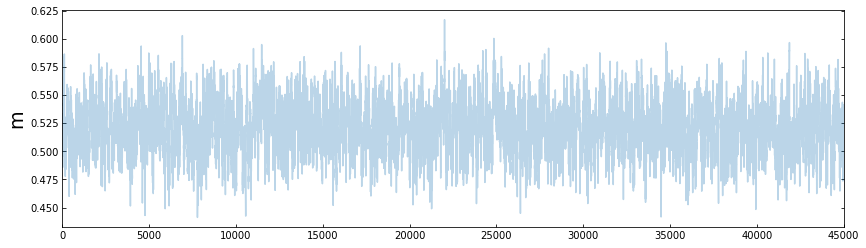

In [7]:
plt.figure(figsize=(14, 4))
samps.m.plot(alpha=0.3)
plt.ylabel('m', fontsize=19)

Text(0,0.5,u'b')

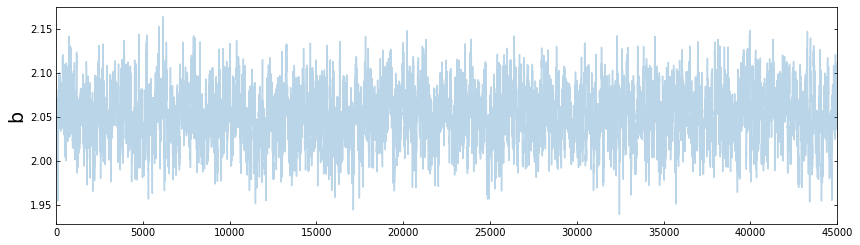

In [8]:
plt.figure(figsize=(14, 4))
samps.b.plot(alpha=0.3)
plt.ylabel('b', fontsize=19)

Text(0,0.5,u's')

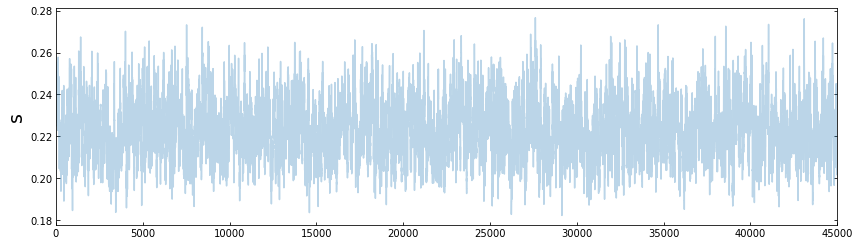

In [9]:
plt.figure(figsize=(14, 4))
samps.s.plot(alpha=0.3)
plt.ylabel('s', fontsize=19)

In [10]:
# WE TAKE THE MAXIMUM LIKELIHOOD RETURNED VALUES TO BE THE TRUE ONES.
m_true, b_true, s_true = result.x

In [11]:
# get the 1-sigma quantiles for the MCMC chains (samples) each parameter. 
m_mcmc, b_mcmc, s_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                                zip(*np.percentile(samples, [15.865, 50, 84.135], axis=0)))

In [12]:
m_mcmc, b_mcmc, s_mcmc

((0.520499335064039, 0.022091665691853168, 0.021201033253882562),
 (2.0526252198922106, 0.0273166480672975, 0.028518306861310627),
 (0.22217803617619963, 0.012940018262427633, 0.011813517552351716))

In [13]:
for name,v in zip(['m','b','s'],[m_mcmc, b_mcmc, s_mcmc]):
    print('%s:  %.3f %.3f %.3f'%(name, v[0], v[1], v[2]))

m:  0.520 0.022 0.021
b:  2.053 0.027 0.029
s:  0.222 0.013 0.012


In [14]:
# average the lower and upper errors
m_err = (m_mcmc[1] + m_mcmc[2])/2.0
b_err = (b_mcmc[1] + b_mcmc[2])/2.0
s_err = (s_mcmc[1] + s_mcmc[2])/2.0

print('\n\n')
print('log(Epk) = b + m log(Eiso)')
print(' b = %.3f (+- %.3f) \n m = %.3f (+- %.3f) \n s = %.2f (+- %.2f)'%(b_true, b_err, m_true, m_err, s_true, s_err))
print('s is the extrinsic scatter (sigma param). ')




log(Epk) = b + m log(Eiso)
 b = 2.051 (+- 0.028) 
 m = 0.521 (+- 0.022) 
 s = 0.22 (+- 0.01)
s is the extrinsic scatter (sigma param). 


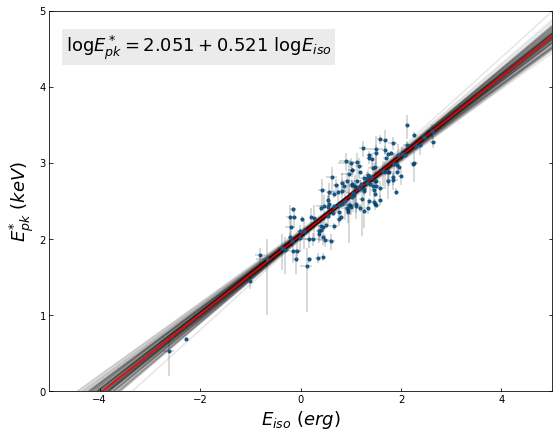

In [15]:
# Plot the linear relations for 100 of the random samples in black
# plot the data 
# plot the MLE linear fit results (the 'true' parameters values) in red. 

props = dict(boxstyle=None, facecolor='gainsboro', linewidth=0.0, alpha=0.57)

plt.figure(figsize=(9,7))
xl = np.array([-10, 10])
# Choose 100 random samples to plot. 
for m, b, s in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m * xl + b, color="k", alpha=0.1)
plt.plot(xl, m_true * xl + b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(xdata, ydata, 
             xerr=[xerrL, xerrU], 
             yerr=[yerrL, yerrU],
             fmt=".k", 
             capsize=0, alpha=0.2)


#plt.plot(x, 0.9 * x + b_true, color='green')
plt.plot(xdata, ydata, ".")
plt.figtext(0.15,0.8,'$%s=%.3f + %.3f %s$'%('\log E^*_{pk}',
                                  b_true, m_true,
                                  ' \ \log E_{iso}'), 
                                    fontsize=18,
                                     bbox=props)                                 
plt.ylim(0,5)
plt.xlim(-5,5)
plt.ylabel('$E^{*}_{pk}$ ($keV$)', fontsize=18)
plt.xlabel('$E_{iso}$ ($erg$)', fontsize=18)
plt.show()

# Corner Plot

Text(0.5,0.745,u' $b \\ =2.051(\\pm0.028)$ \n $m=0.521(\\pm0.022)$ \n $\\sigma_{ext}=0.22 (\\pm0.01)$')

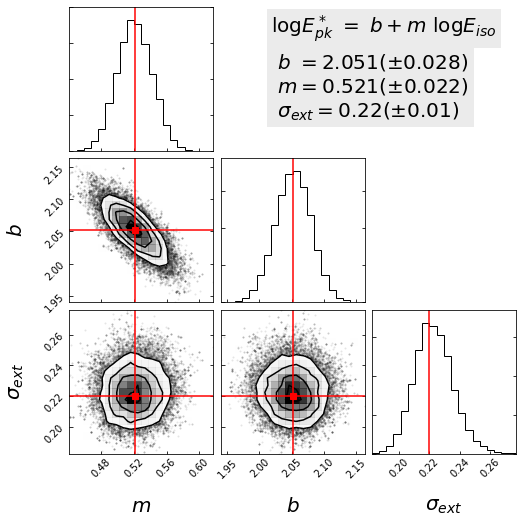

In [16]:
props = dict(boxstyle=None, facecolor='gainsboro', linewidth=0.0, alpha=0.57)
            
label_dict = dict(fontsize=20)
fig = corner.corner(samples, 
                    labels=["$m$", "$b$", "$\sigma_{ext}$"], 
                    truth_color='red', 
                    label_kwargs=label_dict,
                    truths=[m_true, b_true, s_true])
                    
plt.figtext(0.5, 0.9,'$\log E^*_{pk} \ =\ b + m \ \log E_{iso}$', fontsize = 20, bbox=props)
plt.figtext(0.5, 0.745,' $b \ =%.3f(\pm%.3f)$ \n $m=%.3f(\pm%.3f)$ \n $\sigma_{ext}=%.2f (\pm%.2f)$'%(b_true, b_err, m_true, m_err, s_true, s_err), 
            fontsize = 20, bbox=props)
            